In [50]:
library(Seurat)
library(data.table)
library(Matrix)
library(future)
library(dplyr)
library(tidyr)
library(patchwork)
library(ggplot2)
library(ggrepel)
library(ggpubr)
library(grid)
library(Matrix)
library(doParallel)
library(FNN)
library(glue)
library(edgeR)
library(harmony)
library(SeuratDisk)
library(spacexr)
library(tidyverse)
library(hrbrthemes)
library(viridis)
library(ggbeeswarm)

In [51]:
options(future.globals.maxSize = 32000 * 1024^2)
plan("multicore", workers = 12)
plan()

multicore:
- args: function (..., workers = 12, envir = parent.frame())
- tweaked: TRUE
- call: plan("multicore", workers = 12)

### Load Integrated RCTD Slides

In [52]:
nano.obj <- readRDS("data/cosmx_cHL.rds")
nano.obj

An object of class Seurat 
1956 features across 317442 samples within 2 assays 
Active assay: SCT (978 features, 978 variable features)
 1 other assay present: Nanostring
 4 dimensional reductions calculated: pca, harmony, umap, tsne

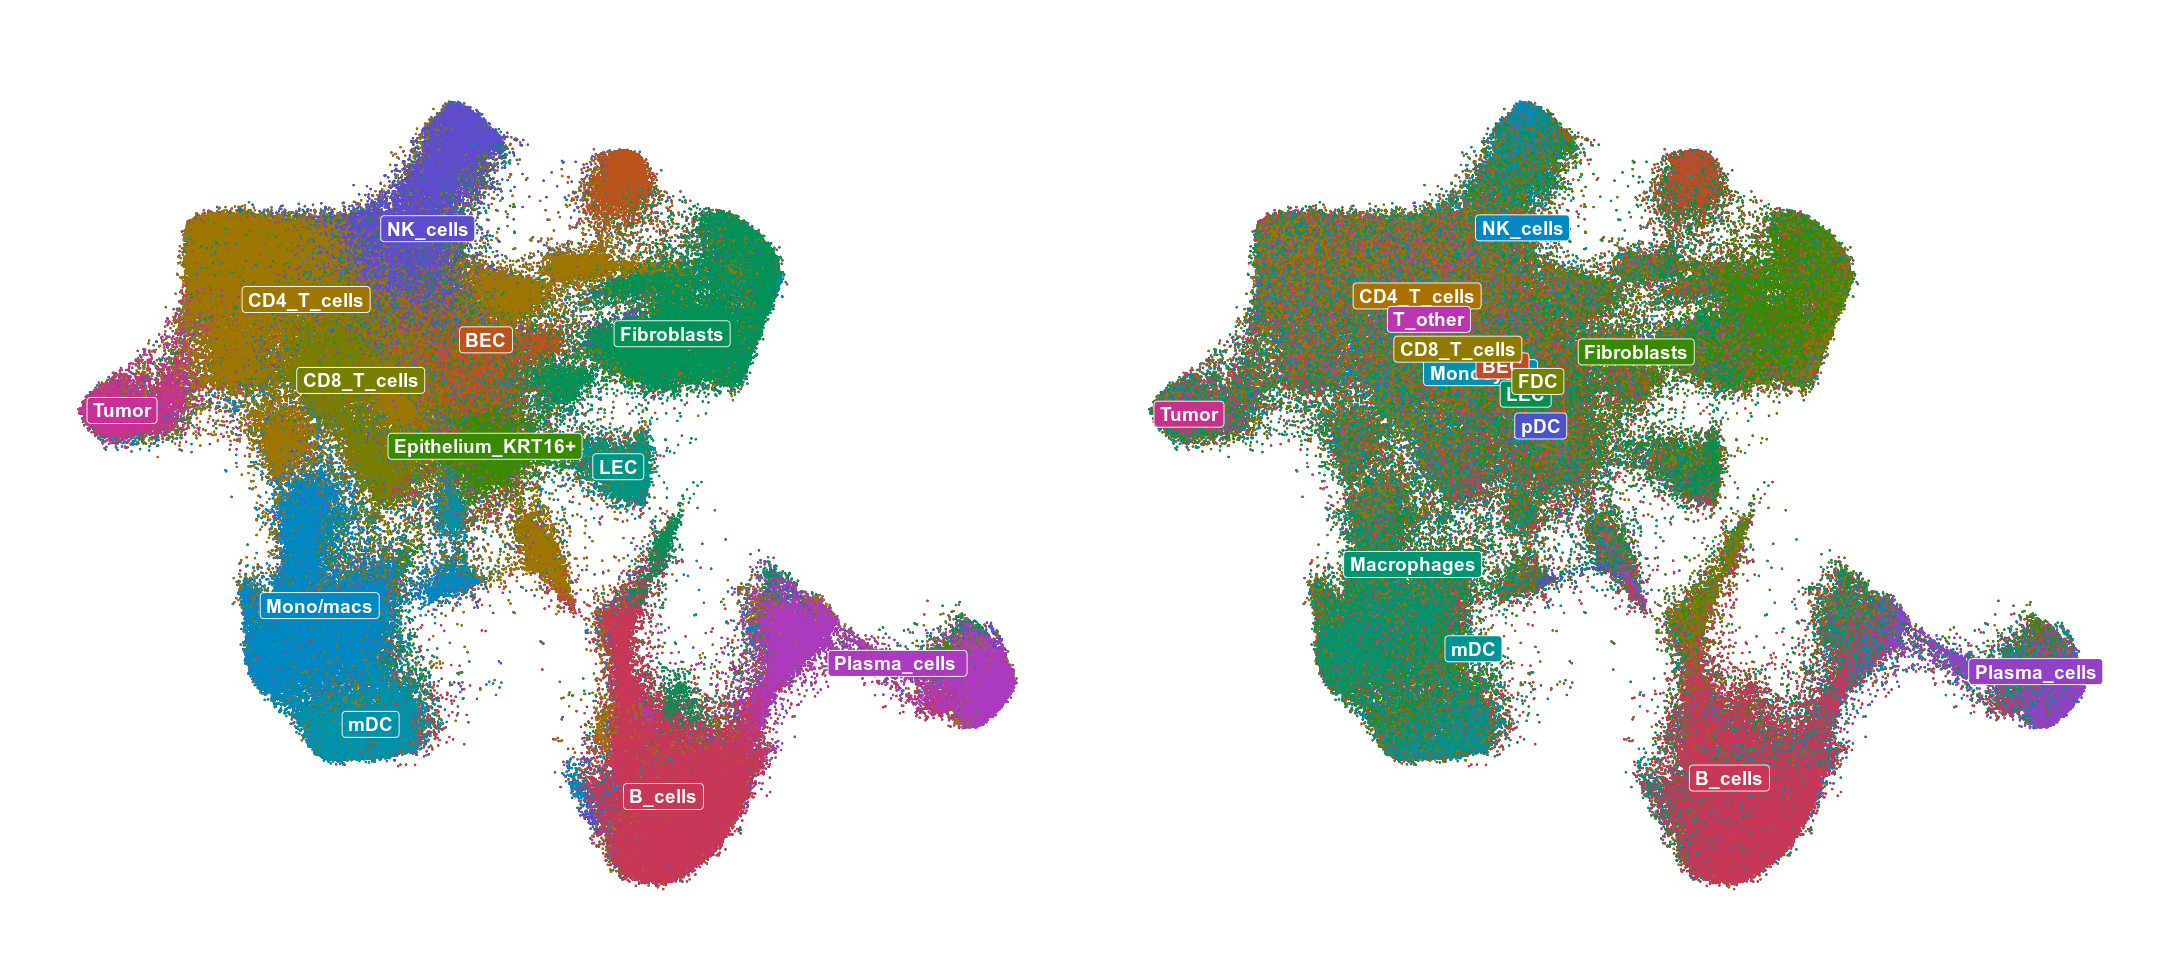

In [4]:
options(repr.plot.width=18, repr.plot.height=8)
p1 <- SCpubr::do_DimPlot(
    sample=nano.obj, 
    group.by='cell_types_level_3', 
    shuffle=FALSE, 
    pt.size=.05, 
    label=TRUE, 
    border.size=.025
) + NoLegend()

p2 <- SCpubr::do_DimPlot(
    sample=nano.obj, 
    group.by='first_type', 
    shuffle=FALSE, 
    pt.size=.05, 
    label=TRUE, 
    border.size=.025
) + NoLegend()

p1 | p2 

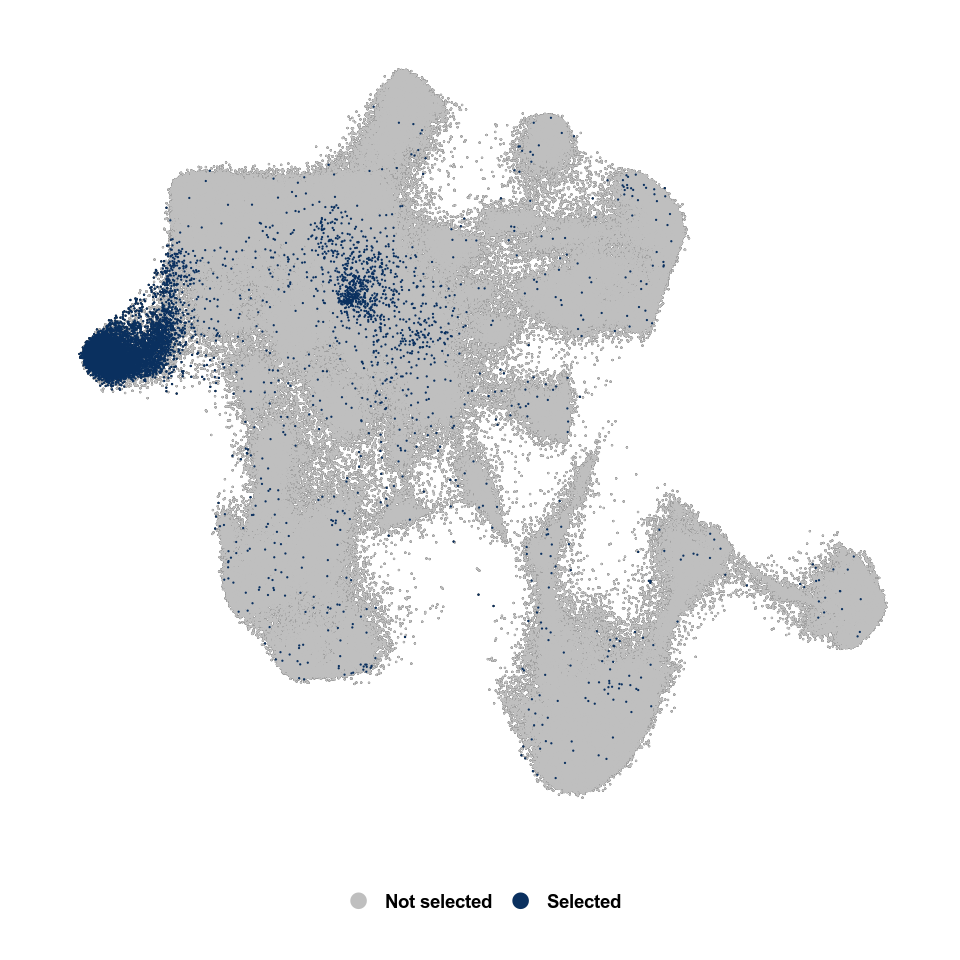

In [5]:
Idents(nano.obj) <- 'cell_types_level_3'
cells <- WhichCells(nano.obj, ident = 'Tumor')
options(repr.plot.width=8, repr.plot.height=8)
p4 <- SCpubr::do_DimPlot(sample=nano.obj, shuffle=TRUE, pt.size=.01, 
                         cells.highlight = cells, label=TRUE, sizes.highlight = .001,
                         border.size=.25) 
p4

In [5]:
nano.obj@meta.data['patient.id'] <- paste('P', nano.obj@meta.data$patient)

### Distance to nearest Tumor

In [7]:
for (slidefov in unique(nano.obj@meta.data$slide.fov) ) {
    fov.xy <- nano.obj@meta.data[nano.obj[["slide.fov"]] == slidefov, 
                                 c("CenterX_local_px", "CenterY_local_px")]
    fov.tumor.xy <- nano.obj@meta.data[nano.obj[["slide.fov"]] == slidefov &
                                   nano.obj[["cell_types_level_3"]] == 'Tumor', 
                                   c("CenterX_local_px", "CenterY_local_px")]
    g = get.knnx(fov.tumor.xy, fov.xy, k=1)
    nano.obj@meta.data[nano.obj[["slide.fov"]] == slidefov, 'dist.from.HRS'] <- as.data.frame(g$nn.dis)$V1
}

In [6]:
print(min(nano.obj[['dist.from.HRS']]))
print(max(nano.obj[['dist.from.HRS']]))

[1] 0
[1] 2085.718


In [ ]:
saveRDS(nano.obj, "data/cosmx_cHL.rds")
SaveH5Seurat(nano.obj, "data/cosmx_cHL.h5Seurat", overwrite = TRUE)
Convert("data/cosmx_cHL.h5Seurat", dest = "h5ad", overwrite=TRUE)

### Proximal vs distal expression

In [4]:
chl.macs <- subset(nano.obj, first_type == 'Macrophages')

In [12]:
chl.macs@meta.data['patient.id.fov'] <- paste0(chl.macs@meta.data$patient.id, '.', chl.macs@meta.data$fov)

In [14]:
chl.macs@meta.data[chl.macs@assays$Nanostring@counts['CD274',] > 0, 'CD274'] <- 'CD274+'
chl.macs@meta.data[chl.macs@assays$Nanostring@counts['CD274',] == 0, 'CD274'] <- 'CD274-'

In [21]:
df.summary <- chl.macs@meta.data %>%
  group_by(patient.id.fov, CD274) %>%
  summarise(
    patient.id = patient.id,
    sd = sd(dist.from.HRS, na.rm = TRUE),
    mean.dist = mean(dist.from.HRS)
  )

`summarise()` has grouped output by 'patient.id.fov', 'CD274'. You can override using the `.groups`
argument.


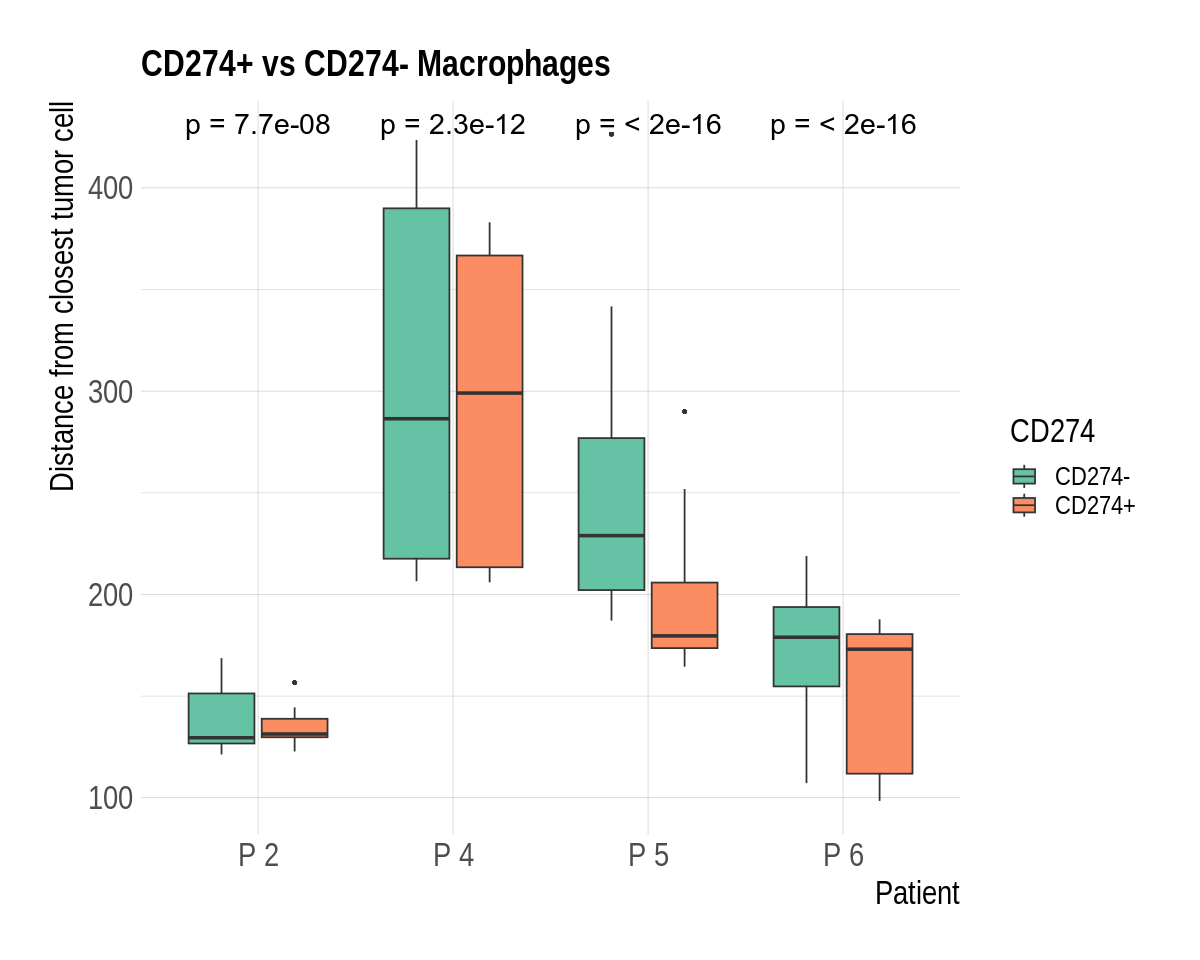

In [46]:
options(repr.plot.width=10, repr.plot.height=8)
df.summary %>%
  ggplot( aes(x=patient.id, y=mean.dist, fill=CD274)) +
    geom_boxplot(outlier.size=0.5) + 
    scale_fill_brewer(palette="Set2") +
    theme_ipsum(base_size=20, axis_title_size=20) +
    theme(plot.title = element_text(size=22) ) + 
    stat_compare_means(method = "wilcox.test", label = "p.format", paired = F, size = 6) +
    ggtitle("CD274+ vs CD274- Macrophages") +
    xlab("Patient") +
    ylab("Distance from closest tumor cell")


Warning message:
“The dot-dot notation (`..p.format..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(p.format)` instead.”


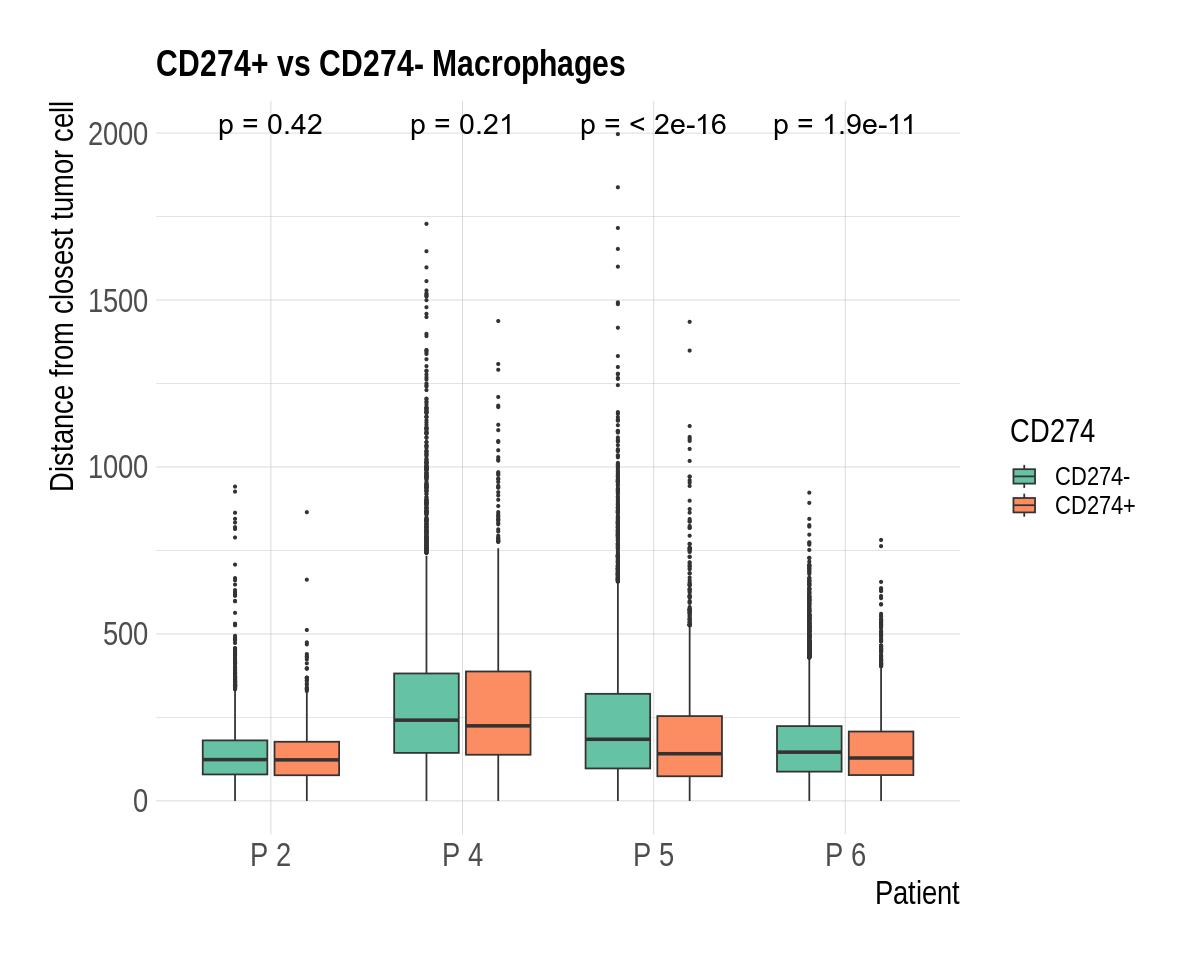

In [11]:
options(repr.plot.width=10, repr.plot.height=8)
chl.macs@meta.data %>%
  ggplot( aes(x=patient.id, y=dist.from.HRS, fill=CD274)) +
    geom_boxplot(outlier.size=0.5) +
    scale_fill_brewer(palette="Set2") +
    theme_ipsum(base_size=20, axis_title_size=20) +
    theme(
      plot.title = element_text(size=22)
      
    ) + 
    stat_compare_means(method = "wilcox.test", label = "p.format", paired = F, size = 6) +
    ggtitle("CD274+ vs CD274- Macrophages") +
    xlab("Patient") +
    ylab("Distance from closest tumor cell")


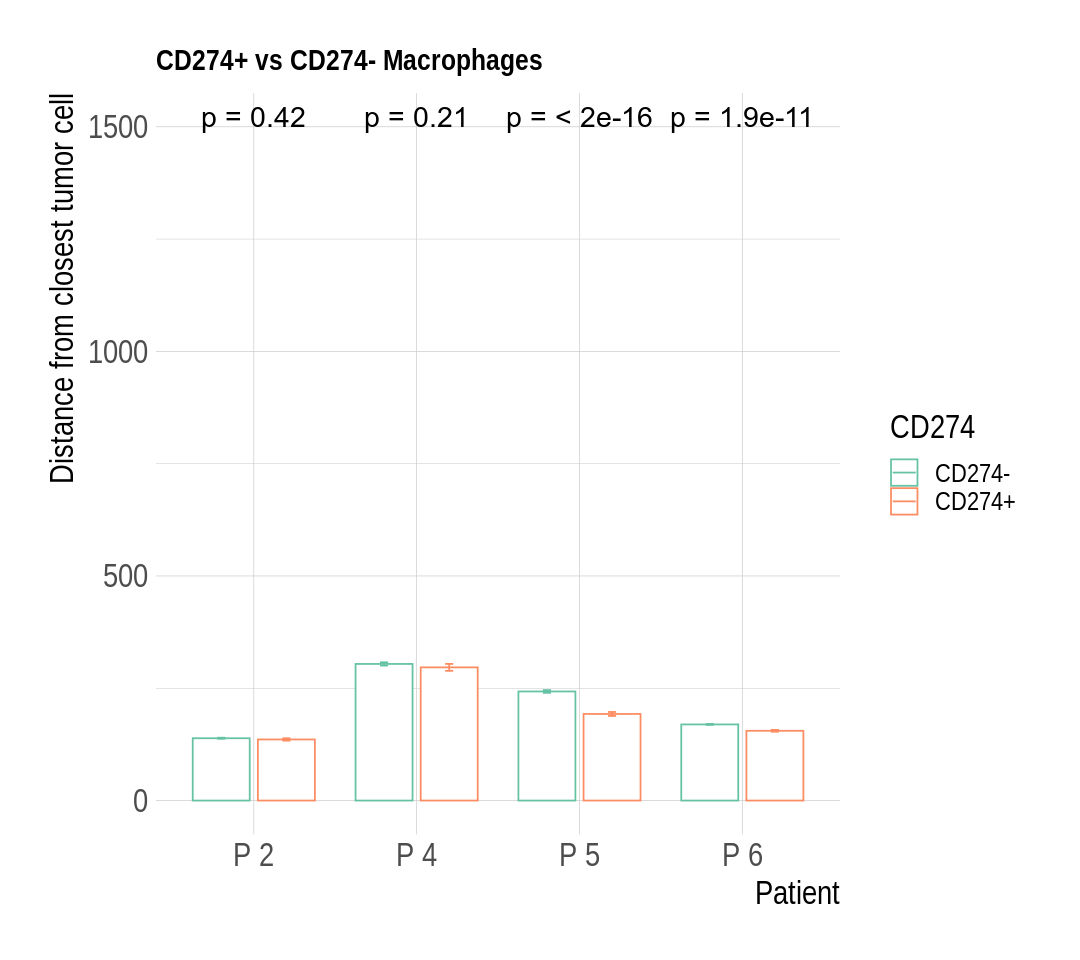

In [12]:
options(repr.plot.width=9, repr.plot.height=8)
ggbarplot(chl.macs@meta.data, x = "patient.id", y = "dist.from.HRS", add = "mean_se",
          color = "CD274",  palette = "Set2", 
          position = position_dodge(0.8))+ theme_ipsum(base_size=20, axis_title_size=20) +
    ggtitle("CD274+ vs CD274- Macrophages") +
    xlab("Patient") +
    ylab("Distance from closest tumor cell") +
    stat_compare_means(aes(group = CD274), label = "p.format", label.y = 1500, paired = F, size = 6)

### Function

In [53]:
prox.v.distal <- function(nano.obj, ctype, gene) 
{
    chl.ctype <- subset(nano.obj, cell_types_level_3 == ctype)
    chl.ctype@meta.data[chl.ctype@assays$Nanostring@counts[gene,] > 0, 'Type'] <- paste(gene, '+')
    chl.ctype@meta.data[chl.ctype@assays$Nanostring@counts[gene,] == 0, 'Type'] <- paste(gene, '-')
    
    options(repr.plot.width=10, repr.plot.height=8)
    p <- chl.ctype@meta.data %>%
      ggplot( aes(x=patient.id, y=dist.from.HRS, fill=Type)) +
        geom_boxplot(outlier.size=0.5) +
        scale_fill_brewer(palette="Set2") +
        theme_ipsum(base_size=20, axis_title_size=20) +
        theme(
          plot.title = element_text(size=22)

        ) + 
        stat_compare_means(method = "wilcox.test", label = "p.format", paired = F, size = 6) +
        ggtitle(glue("{gene} + vs {gene} - {ctype}")) +
        xlab("Patient") +
        ylab("Distance from closest tumor cell")
    return(p)
}



In [54]:
prox.v.distal <- function(nano.obj, ctype, gene) 
{
    chl.ctype <- subset(nano.obj, first_type == ctype)
    chl.ctype@meta.data[chl.ctype@assays$Nanostring@counts[gene,] > 0, 'Type'] <- paste(gene, '+')
    chl.ctype@meta.data[chl.ctype@assays$Nanostring@counts[gene,] == 0, 'Type'] <- paste(gene, '-')
    
    options(repr.plot.width=10, repr.plot.height=8)
    p <- chl.ctype@meta.data %>%
      ggplot( aes(x=patient.id, y=dist.from.HRS, fill=Type)) +
        geom_boxplot(outlier.size=0.5) +
        scale_fill_brewer(palette="Set2") +
        theme_ipsum(base_size=20, axis_title_size=20) +
        theme(
          plot.title = element_text(size=22)

        ) + 
        stat_compare_means(method = "wilcox.test", label = "p.format", paired = F, size = 6) +
        ggtitle(glue("{gene} + vs {gene} - {ctype}")) +
        xlab("Patient") +
        ylab("Distance from closest tumor cell")
    return(p)
}

In [57]:
nano.obj[['first_type']]

An object of class Seurat 
1956 features across 317442 samples within 2 assays 
Active assay: SCT (978 features, 978 variable features)
 1 other assay present: Nanostring
 4 dimensional reductions calculated: pca, harmony, umap, tsne

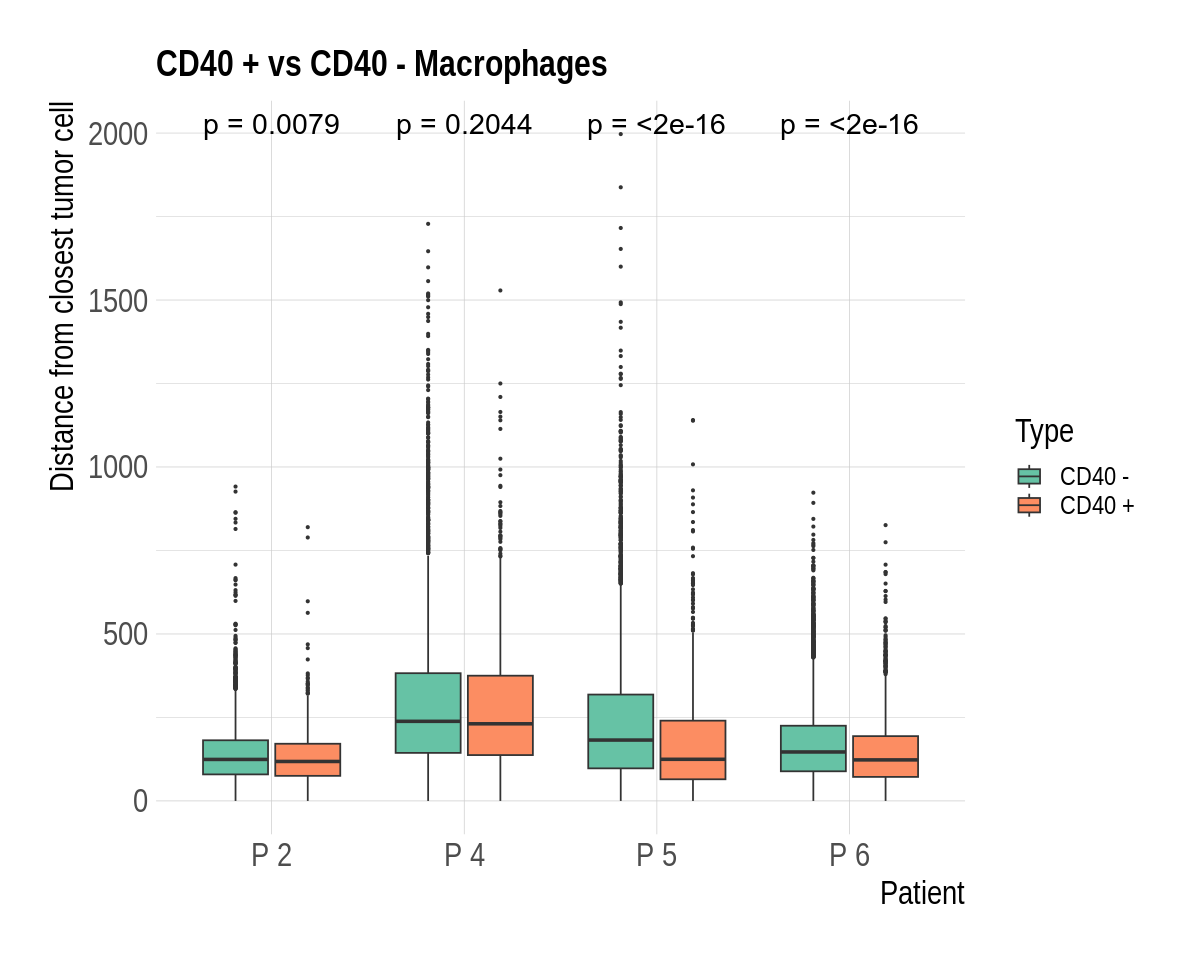

In [61]:
p <- prox.v.distal(nano.obj, 'Macrophages', 'CD40')#CD80/CD86 (macrophages), CTLA4 (T cells) 
ggsave("figures/NFKB1_macs.png", width = 10, height = 8, bg = "white")
p

Warning message:
“The dot-dot notation (`..p.format..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(p.format)` instead.”


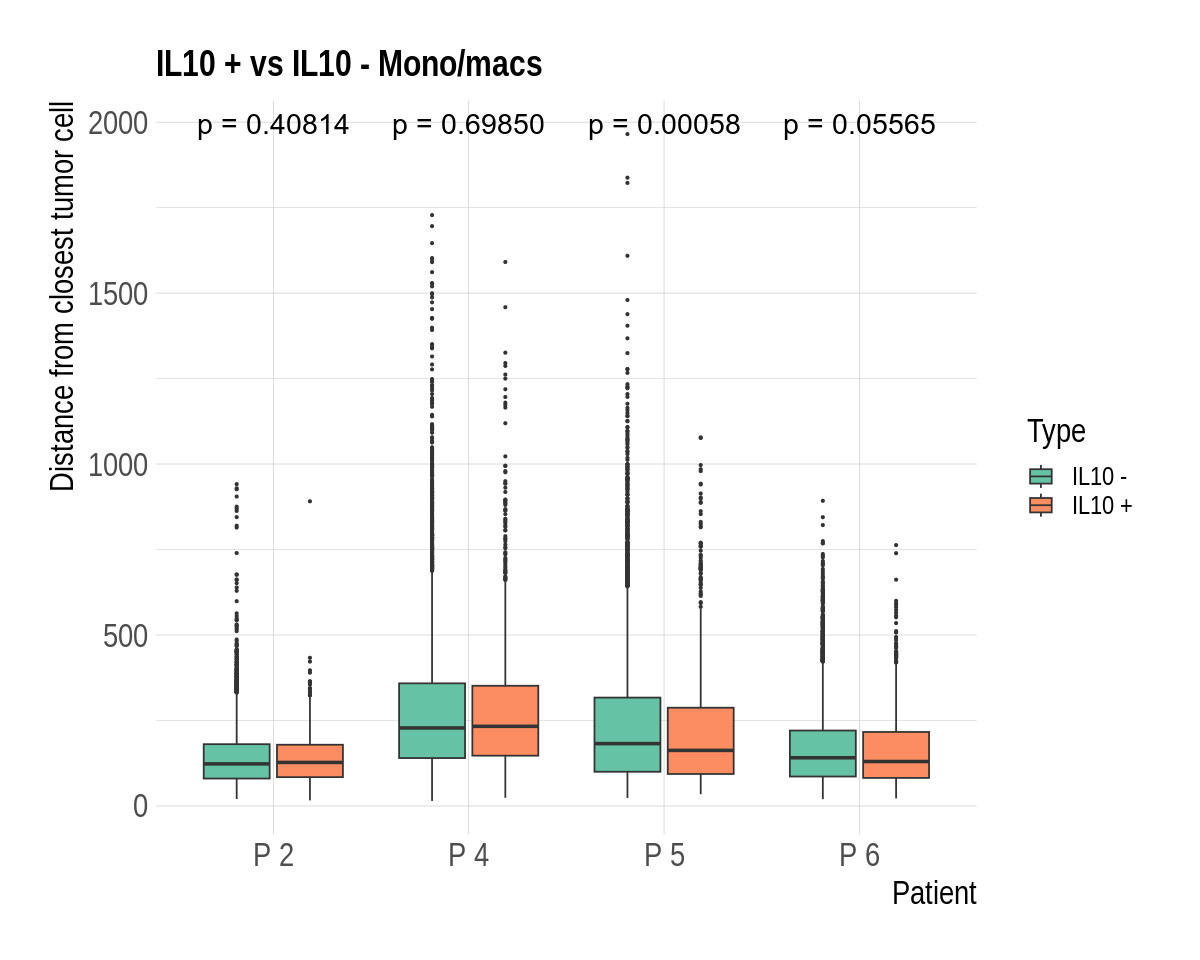

In [8]:
p <- prox.v.distal(nano.obj, 'Mono/macs', 'IL10')#CD80/CD86 (macrophages), CTLA4 (T cells) 
ggsave("figures/il10_macs.png", width = 10, height = 8, bg = "white")
p

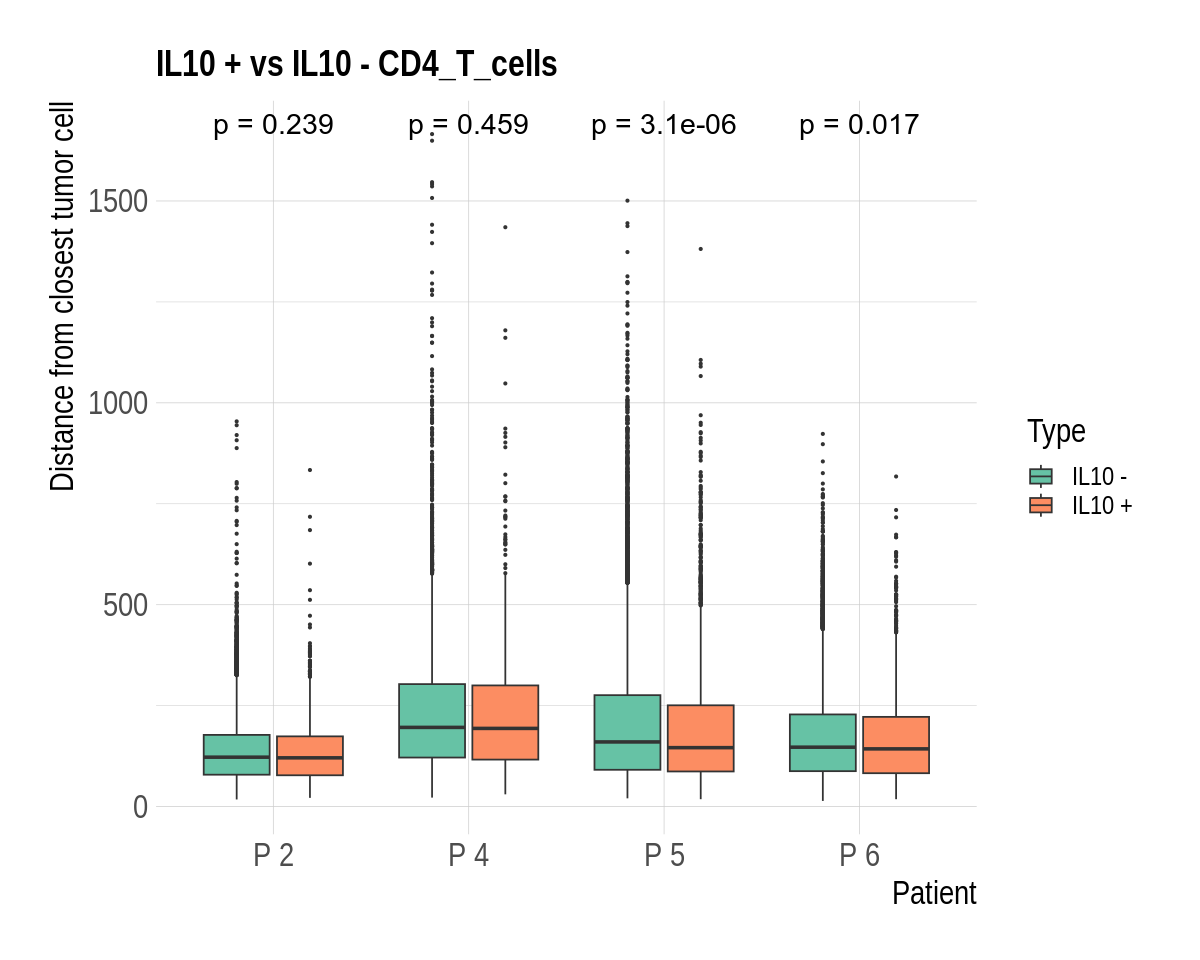

In [9]:
p <- prox.v.distal(nano.obj, 'CD4_T_cells', 'IL10')#CD80/CD86 (macrophages), CTLA4 (T cells) 
ggsave("figures/il10_cd4.png", width = 10, height = 8, bg = "white")
p

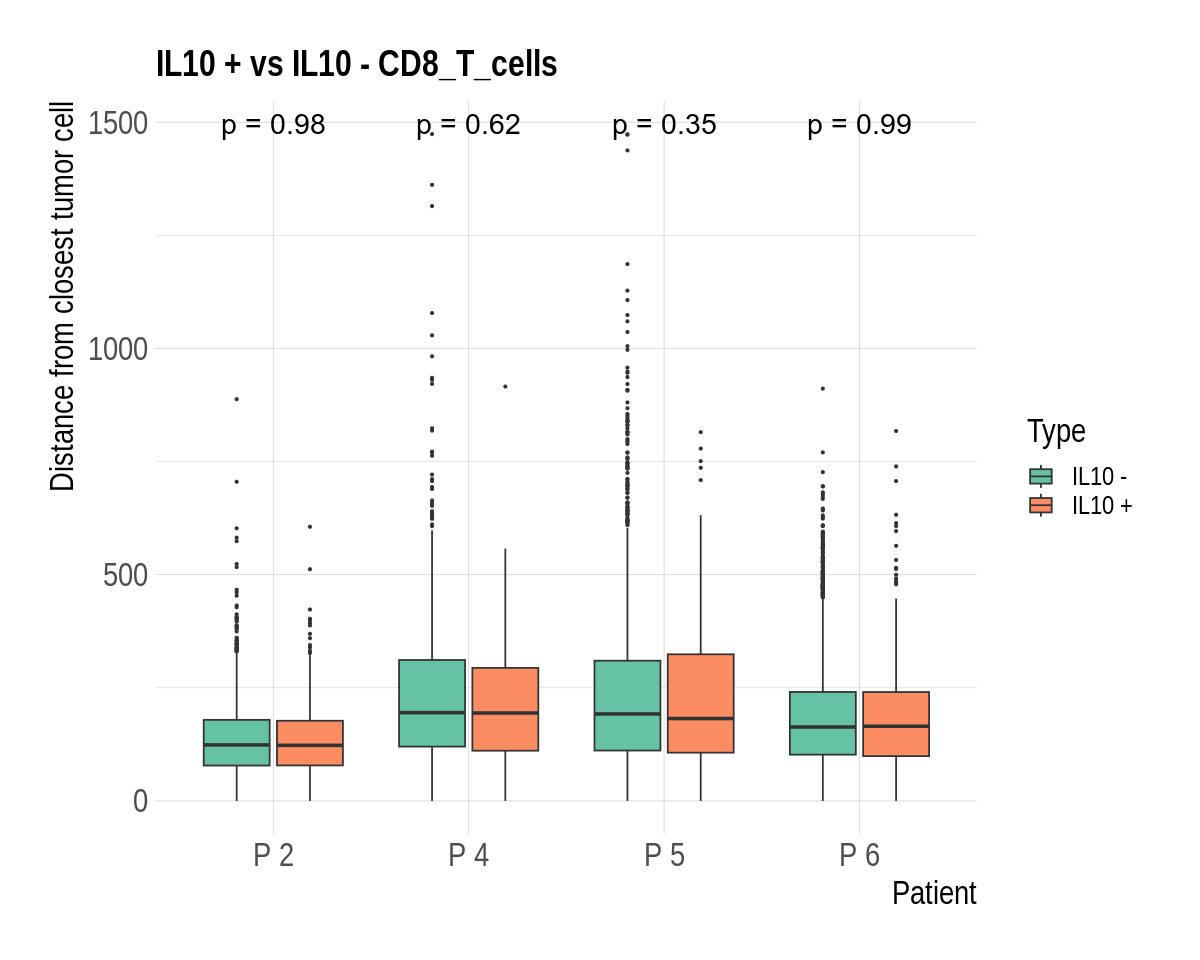

In [44]:
p <- prox.v.distal(nano.obj, 'CD8_T_cells', 'IL10')#CD80/CD86 (macrophages), CTLA4 (T cells) 
ggsave("figures/il10_cd8.png", width = 10, height = 8, bg = "white")
p

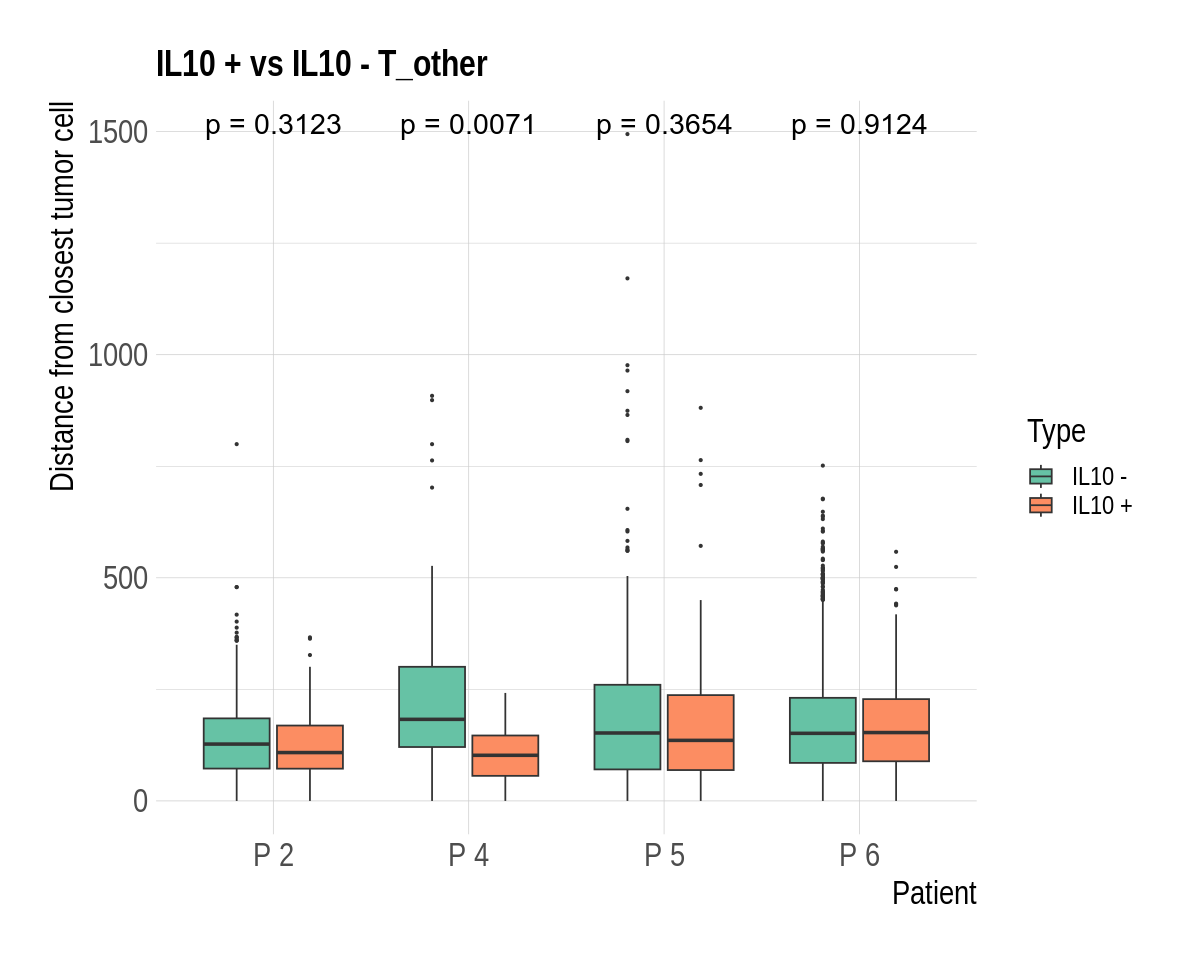

In [45]:
p <- prox.v.distal(nano.obj, 'T_other', 'IL10')#CD80/CD86 (macrophages), CTLA4 (T cells) 
ggsave("figures/il10_tother.png", width = 10, height = 8, bg = "white")
p

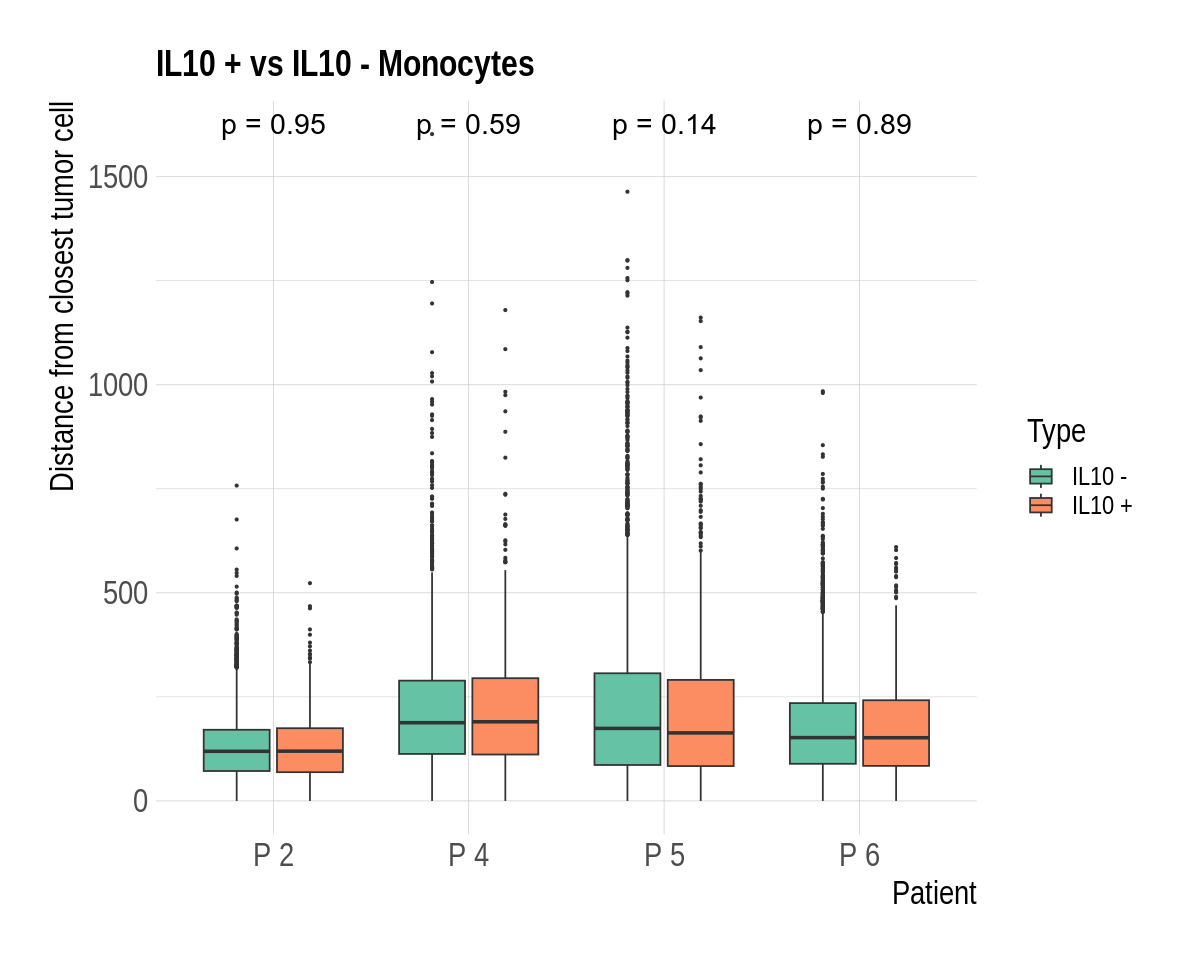

In [48]:
p <- prox.v.distal(nano.obj, 'Monocytes', 'IL10')#CD80/CD86 (macrophages), CTLA4 (T cells) 
ggsave("figures/il10_mono.png", width = 10, height = 8, bg = "white")
p

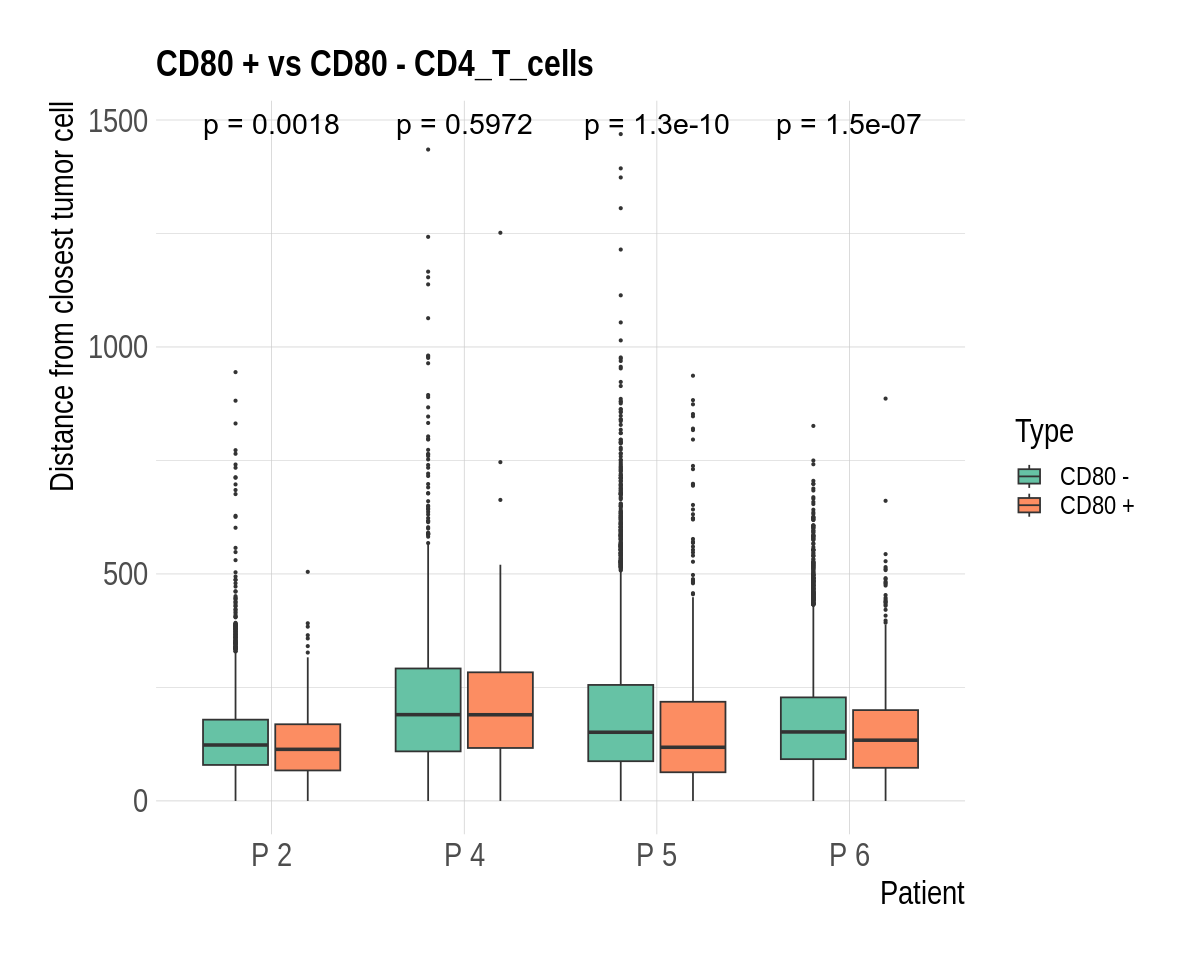

In [ ]:
prox.v.distal(nano.obj, 'Macrophages', 'CD80')#CD80/CD86 (macrophages), CTLA4 (T cells) 

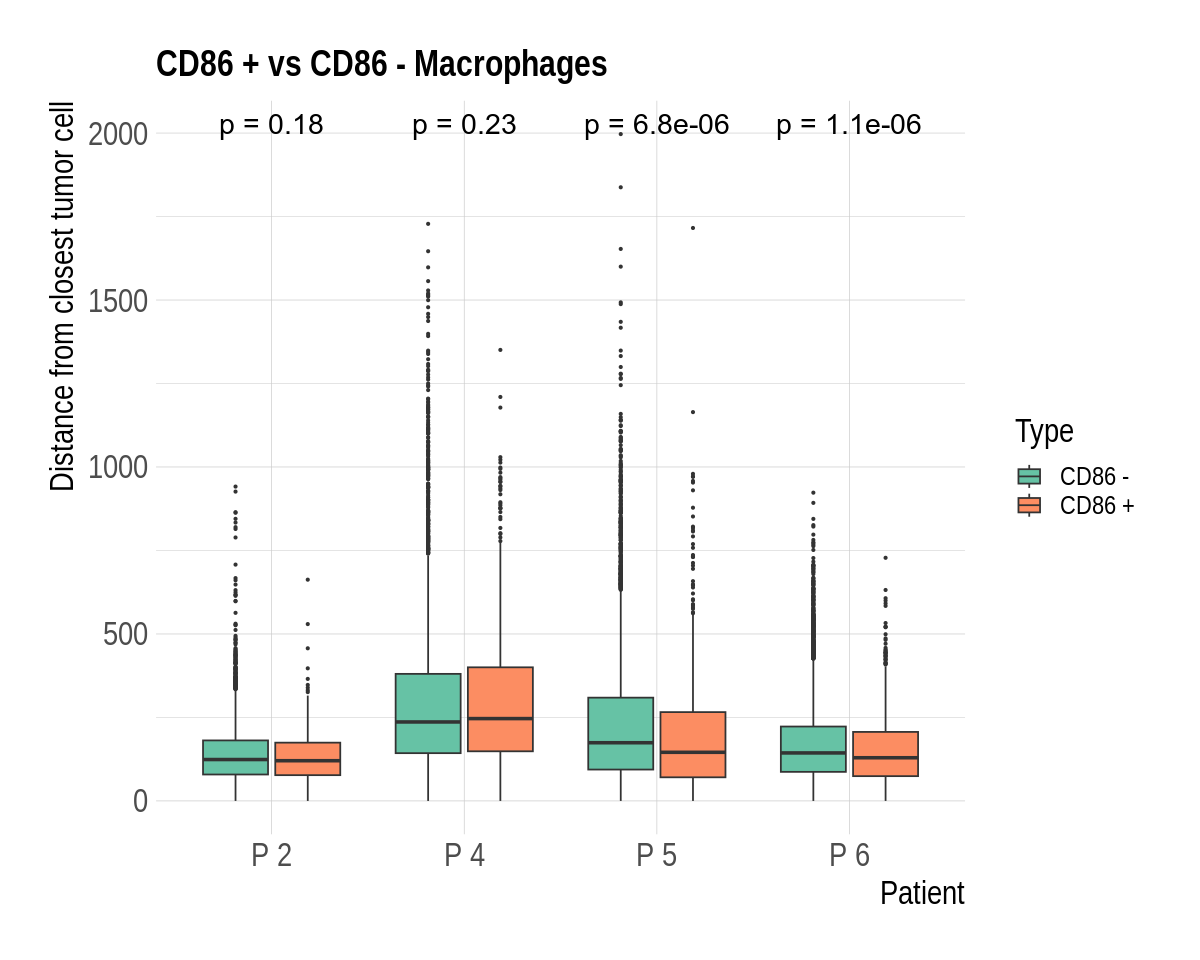

In [18]:
prox.v.distal(nano.obj, 'Macrophages', 'CD86')

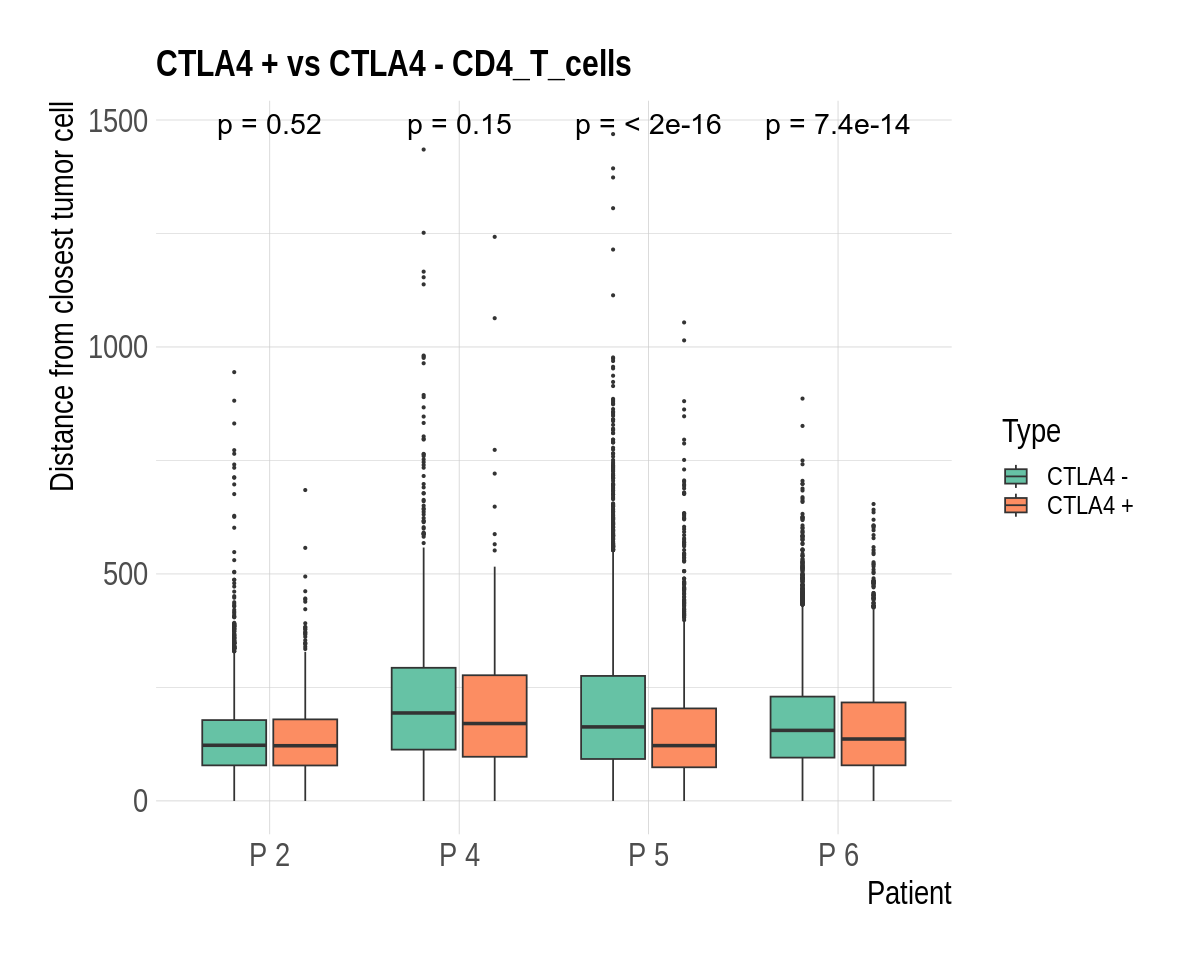

In [19]:
prox.v.distal(nano.obj, 'CD4_T_cells', 'CTLA4')

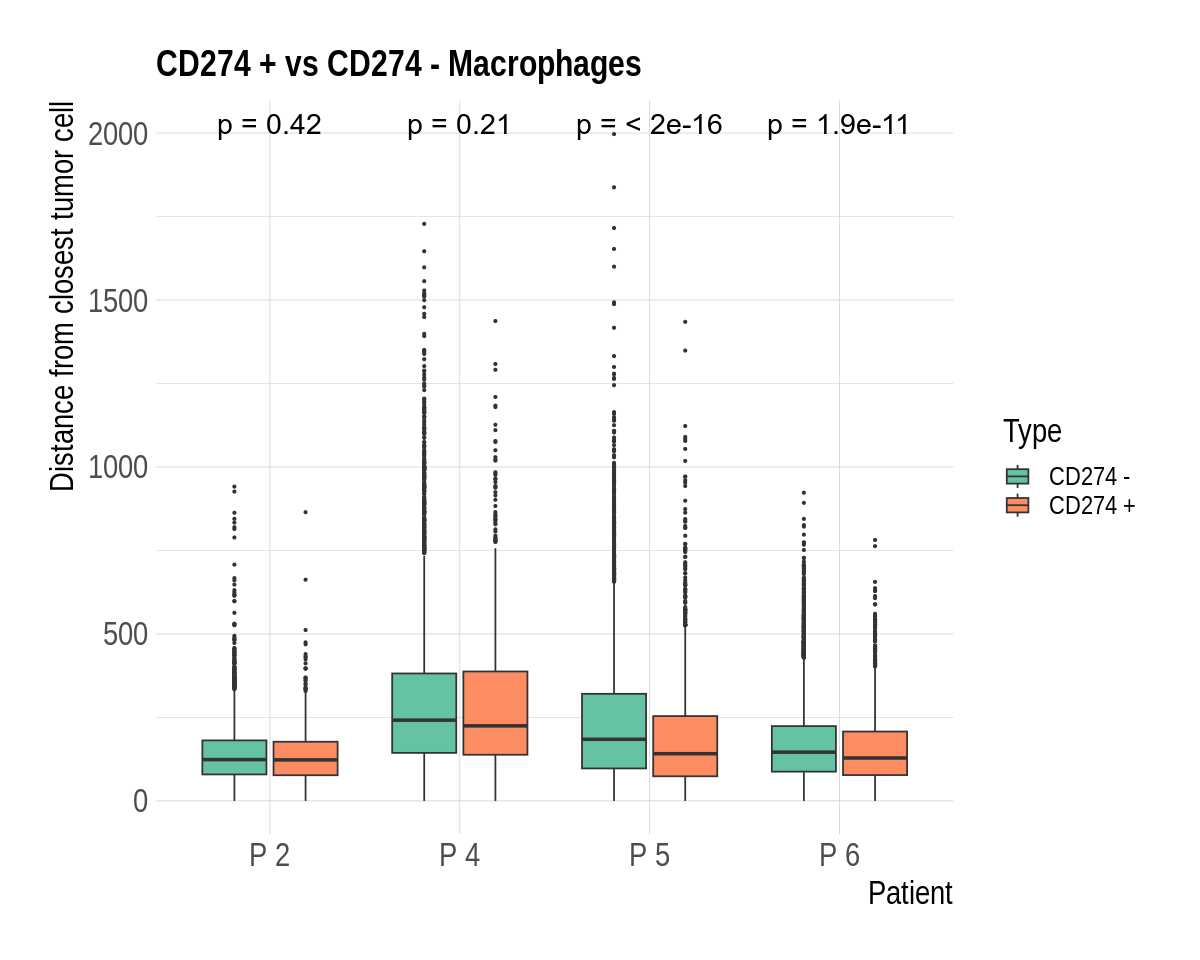

In [20]:
prox.v.distal(nano.obj, 'Macrophages', 'CD274')

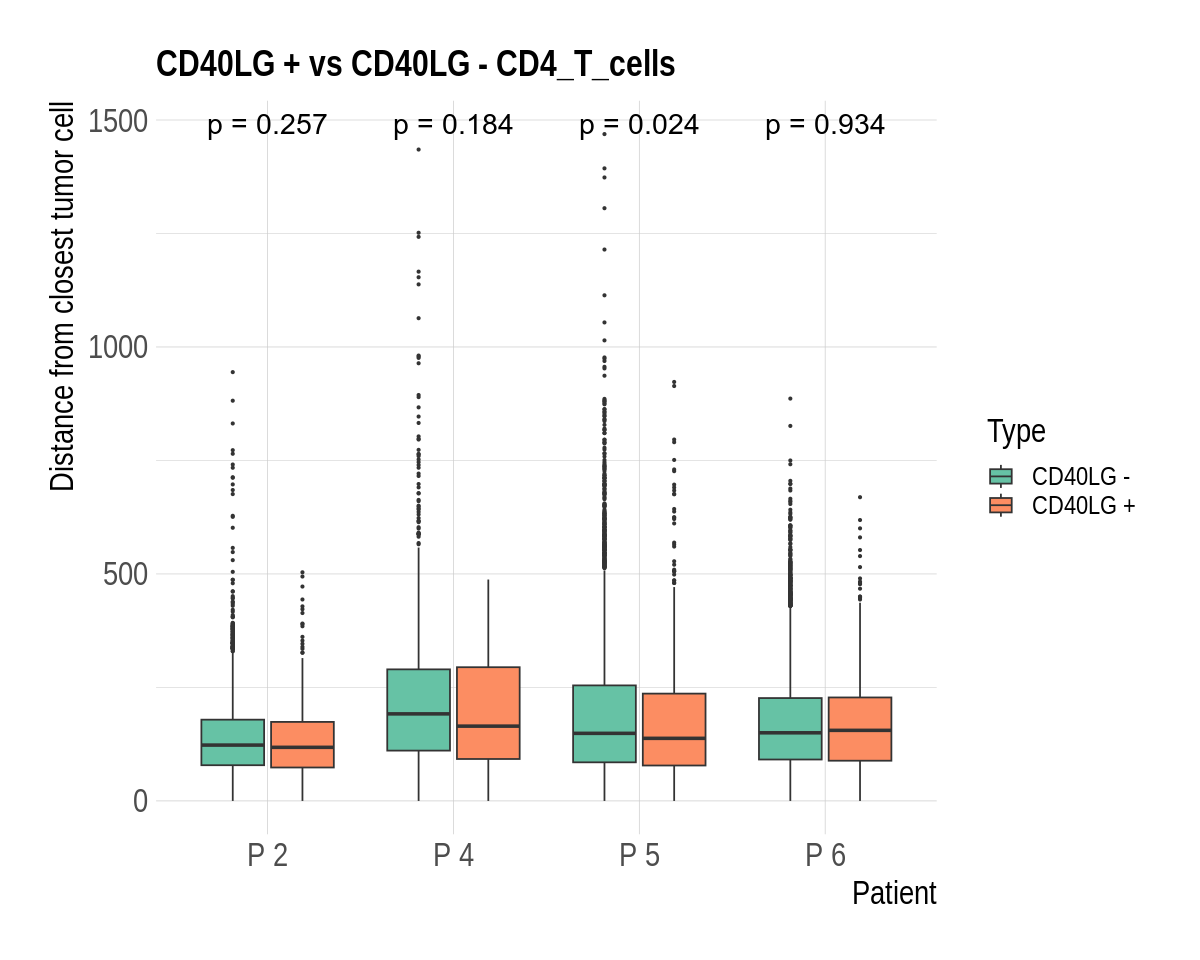

In [21]:
prox.v.distal(nano.obj, 'CD4_T_cells', 'CD40LG')

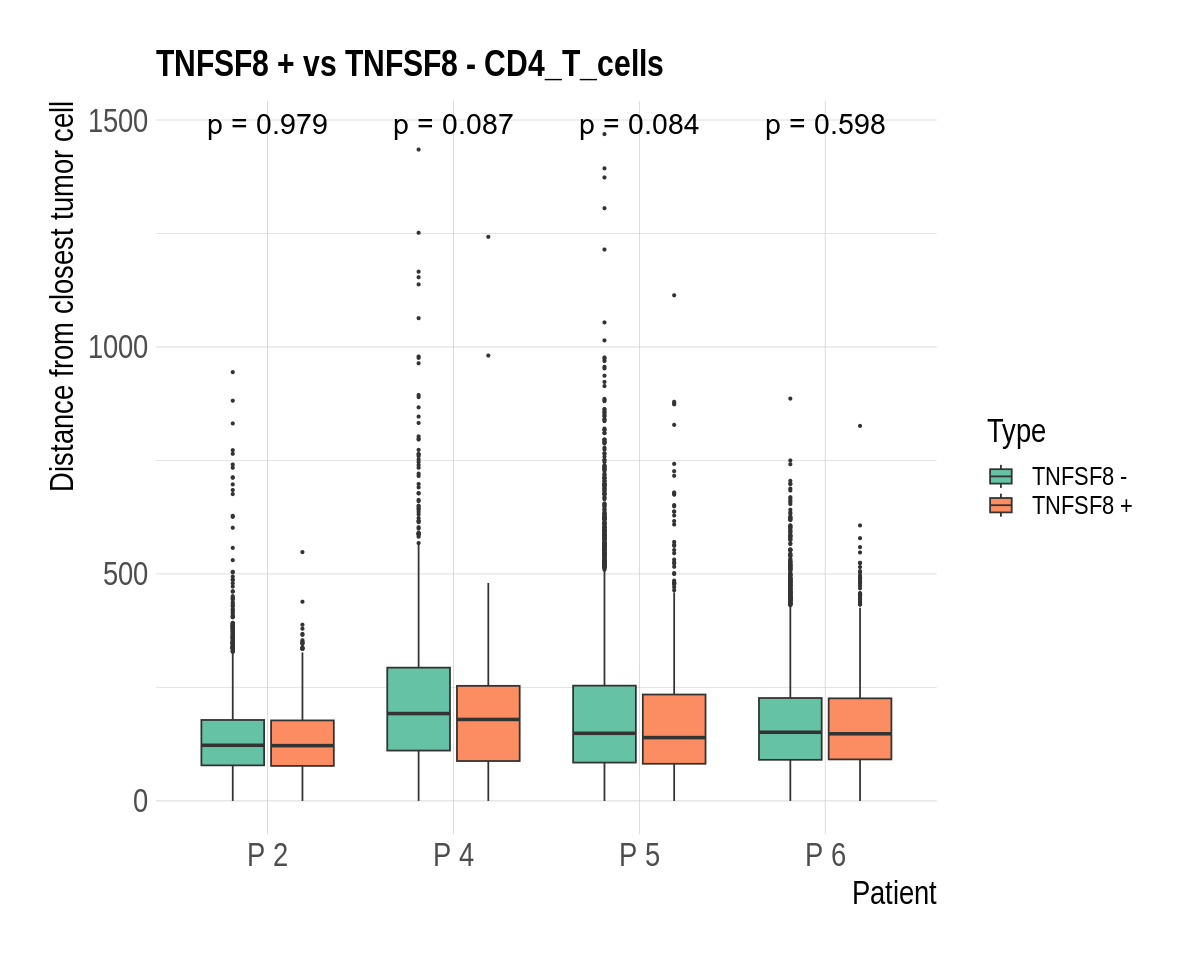

In [22]:
prox.v.distal(nano.obj, 'CD4_T_cells', 'TNFSF8')

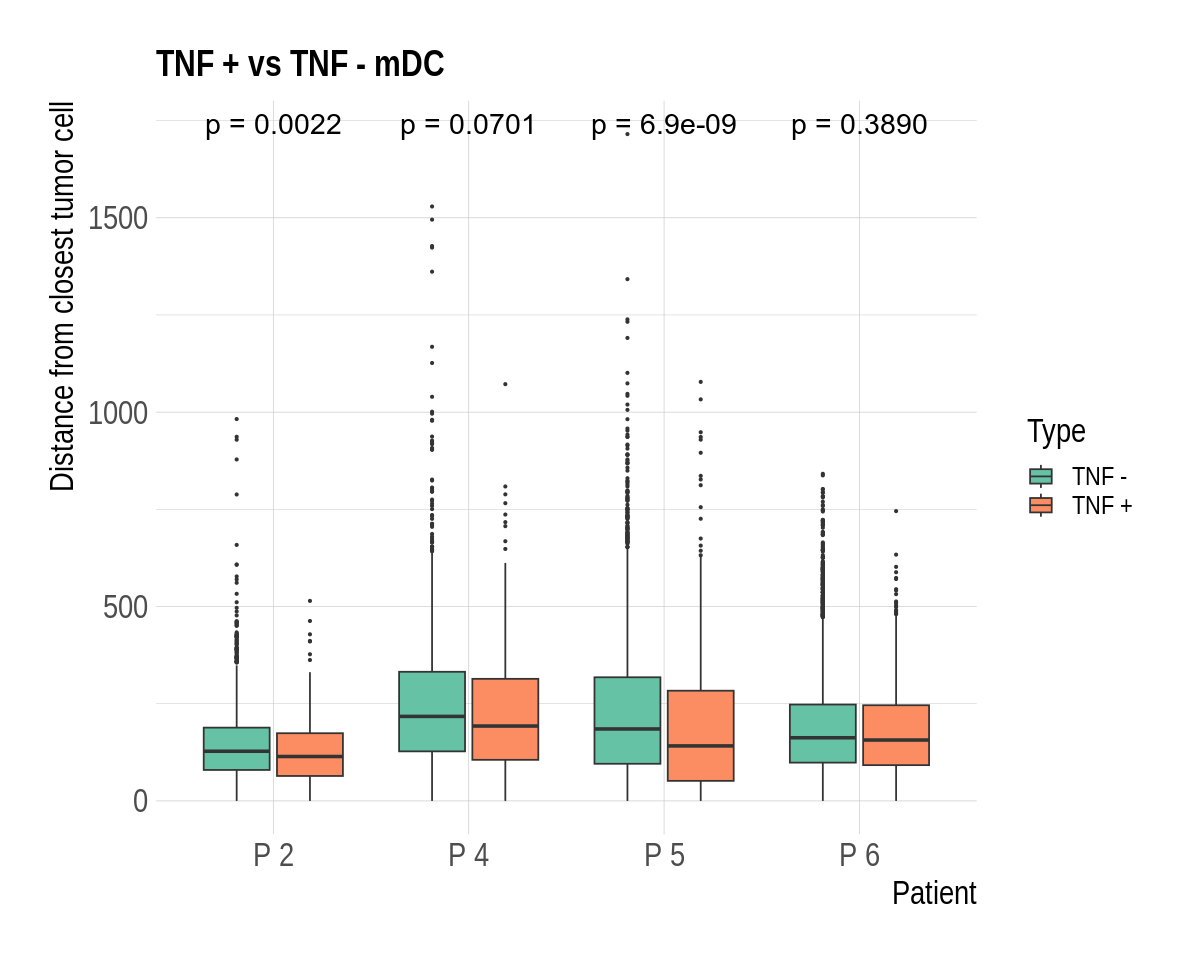

In [23]:
prox.v.distal(nano.obj, 'mDC', 'TNF')

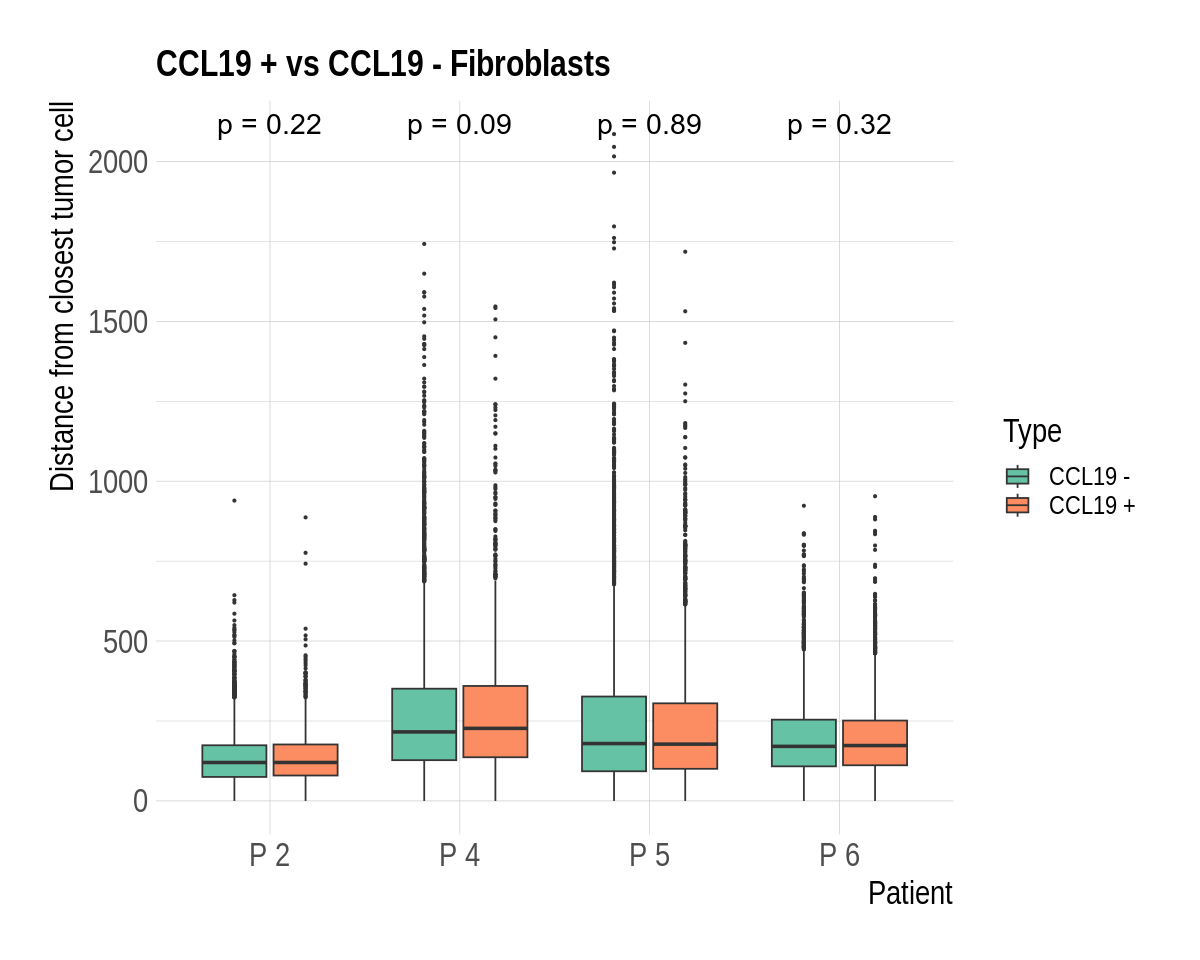

In [24]:
prox.v.distal(nano.obj, 'Fibroblasts', 'CCL19')

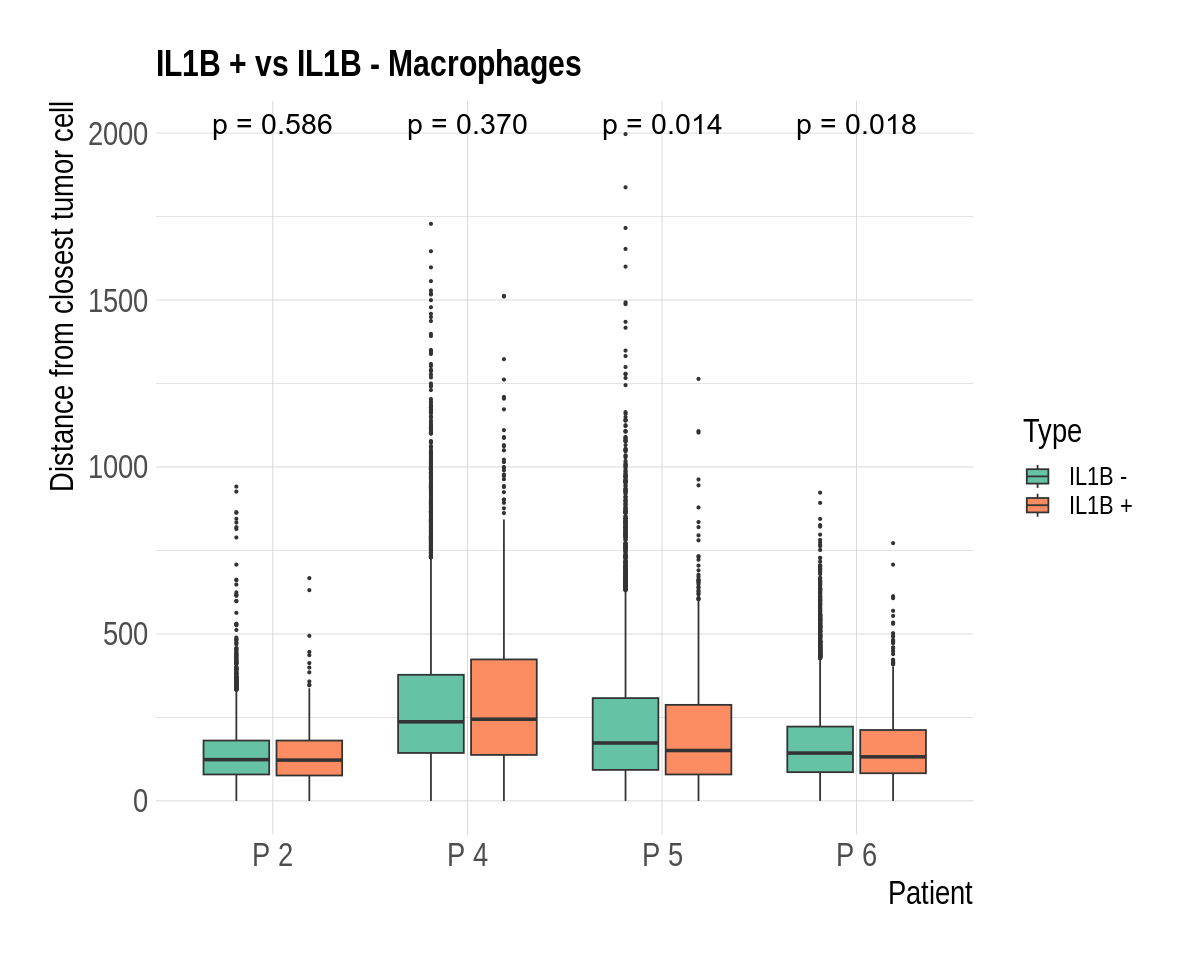

In [25]:
prox.v.distal(nano.obj, 'Macrophages', 'IL1B')

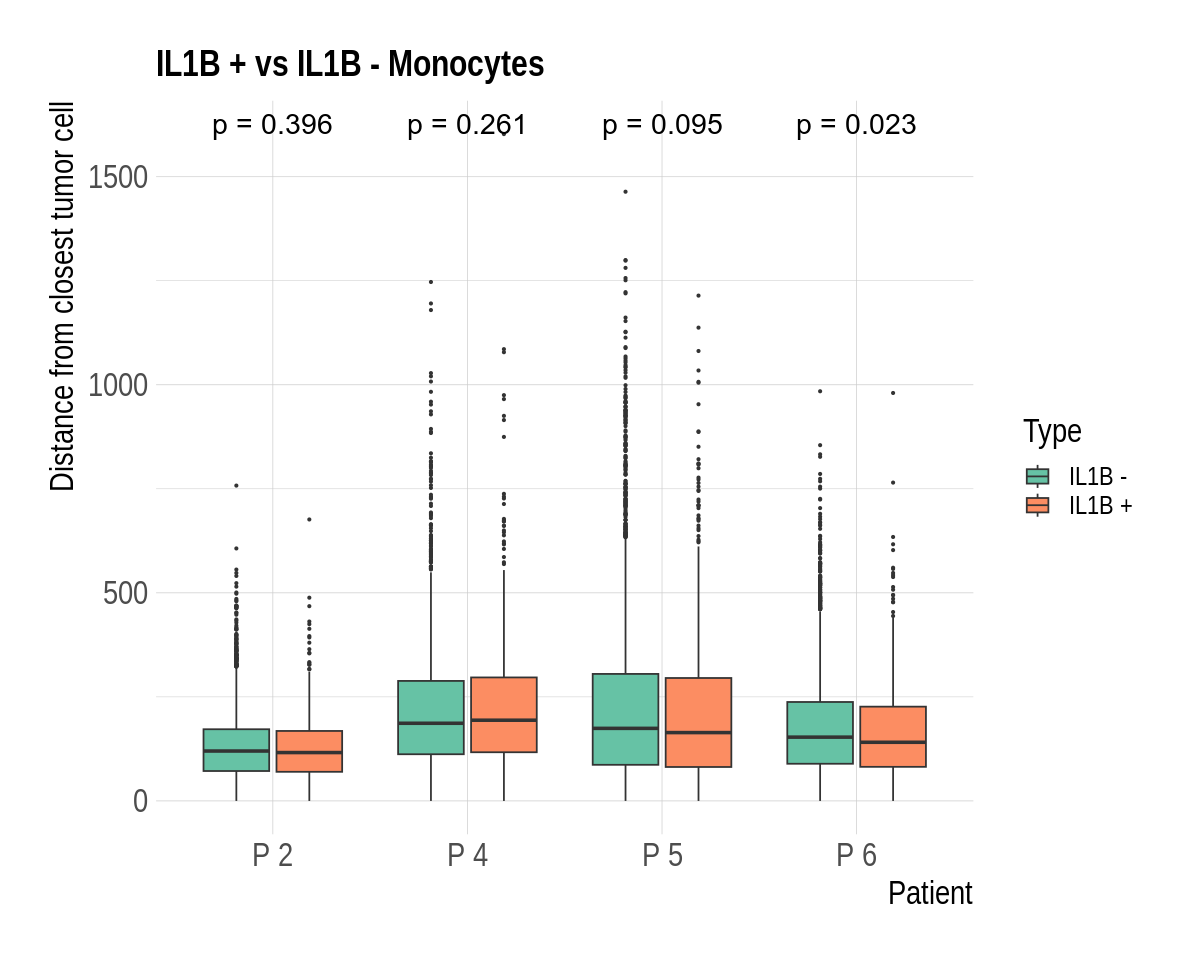

In [26]:
prox.v.distal(nano.obj, 'Monocytes', 'IL1B')

### Save

In [242]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS/LAPACK: /home/dchafamo/anaconda3/envs/muscat2/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] parallel  grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] spacexr_2.0.7         SeuratDisk_0.0.0.9020 harmony_0.1.1        
 [4] Rcpp_1.0.9            edgeR_3.36.0          limma_3.50.3         
 [7] FNN_1.1.3.1           doParallel_1.0.17     iterators_1.0.14     
[10] foreach_1.5.2         ggrepel_0.9.2         ggplot2_3.4.0        
[13] patchwork_1.1.2       tidyr_1.2.1  